In [1]:
# Setup and Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
import yfinance as yf
warnings.filterwarnings('ignore')

print("Volatility Estimators Project")
print("=================================")
print("Notebook 4: Robustness Testing with Real Market Data")
print("Testing sensitivity to different market conditions using yfinance data")

np.random.seed(42)
plt.style.use('seaborn-v0_8')
from volatility_estimators.core import VolatilityEstimators, PerformanceMetrics

print("Libraries imported successfully")

Volatility Estimators Project
Notebook 4: Robustness Testing with Real Market Data
Testing sensitivity to different market conditions using yfinance data
Libraries imported successfully


In [2]:
# Real Market Data Fetcher
class MarketDataFetcher:
    """Fetch and prepare real market data for robustness testing"""
    
    def __init__(self):
        self.tickers = {
            'SPY': 'S&P 500 ETF (General Market)',
            'TLT': '20+ Year Treasury ETF (Low Volatility)',
            'GLD': 'Gold ETF (Commodity)',
            'BTC-USD': 'Bitcoin (High Volatility)',
            'IWM': 'Russell 2000 (Small Cap)',
            'QQQ': 'Nasdaq 100 (Tech)'
        }
    
    def fetch_data(self, ticker, period='2y', interval='1d'):
        """Fetch OHLC data from yfinance"""
        print(f"Fetching data for {ticker}...")
        try:
            stock = yf.Ticker(ticker)
            data = stock.history(period=period, interval=interval)
            
            if data.empty:
                print(f"No data found for {ticker}")
                return None
            
            
            required_cols = ['Open', 'High', 'Low', 'Close']
            if not all(col in data.columns for col in required_cols):
                print(f"Missing required columns for {ticker}")
                return None
            
            
            data = data[required_cols].dropna()
            
            print(f"{ticker}: {len(data)} trading days, {period} period")
            return data
            
        except Exception as e:
            print(f"Error fetching {ticker}: {e}")
            return None
    
    def get_all_market_data(self, period='2y'):
        """Fetch data for all tickers"""
        market_data = {}
        
        for ticker in self.tickers.keys():
            data = self.fetch_data(ticker, period=period)
            if data is not None:
                market_data[ticker] = data
            else:
                print(f"Skipping {ticker} due to data issues")
        
        print(f"\nSuccessfully fetched data for {len(market_data)} assets")
        return market_data


print("Fetching Real Market Data...")
print("=================================")

fetcher = MarketDataFetcher()
market_data = fetcher.get_all_market_data(period='2y')


for ticker, data in market_data.items():
    returns = data['Close'].pct_change().dropna()
    vol_annual = returns.std() * np.sqrt(252)
    print(f"{ticker}: {len(data)} days, Annual Vol: {vol_annual:.3f}")
    

Fetching Real Market Data...
Fetching data for SPY...
SPY: 502 trading days, 2y period
Fetching data for TLT...
TLT: 502 trading days, 2y period
Fetching data for GLD...
GLD: 502 trading days, 2y period
Fetching data for BTC-USD...
BTC-USD: 732 trading days, 2y period
Fetching data for IWM...
IWM: 502 trading days, 2y period
Fetching data for QQQ...
QQQ: 502 trading days, 2y period

Successfully fetched data for 6 assets
SPY: 502 days, Annual Vol: 0.164
TLT: 502 days, Annual Vol: 0.143
GLD: 502 days, Annual Vol: 0.171
BTC-USD: 732 days, Annual Vol: 0.400
IWM: 502 days, Annual Vol: 0.224
QQQ: 502 days, Annual Vol: 0.208


In [ ]:
# Market Regime Detector for Robustness Testing
from volatility_estimators.core import VolatilityEstimators
class MarketRegimeDetector:
    """Detect different market regimes in real data"""
    
    def __init__(self, window=30):
        self.window = window
    
    def detect_high_vol_regime(self, returns):
        """Detect high volatility periods"""
        try:
            rolling_vol = returns.rolling(window=self.window, min_periods=10).std()
            if len(rolling_vol.dropna()) == 0:
                return pd.Series(False, index=returns.index)
            high_vol_threshold = rolling_vol.quantile(0.75)
            return rolling_vol > high_vol_threshold
        except:
            return pd.Series(False, index=returns.index)
    
    def detect_trending_regime(self, prices):
        """Detect strong trending periods (high drift)"""
        try:
            returns = prices.pct_change().dropna()
            rolling_mean = returns.rolling(window=self.window, min_periods=10).mean()
            rolling_std = returns.rolling(window=self.window, min_periods=10).std()
            
            
            trend_strength = np.abs(rolling_mean) / (rolling_std + 1e-8)
            return trend_strength > 0.3  
        except:
            return pd.Series(False, index=prices.index)
    
    def detect_jump_regimes(self, returns, z_threshold=2.5):  
        """Detect periods with significant jumps"""
        try:
            rolling_mean = returns.rolling(window=self.window, min_periods=10).mean()
            rolling_std = returns.rolling(window=self.window, min_periods=10).std()
            z_scores = np.abs((returns - rolling_mean) / (rolling_std + 1e-8))
            return z_scores > z_threshold
        except:
            return pd.Series(False, index=returns.index)
    
    def get_regime_samples(self, ohlc_data, n_samples=50):  
        """Extract samples from different market regimes"""
        try:
            close_prices = ohlc_data['Close']
            returns = close_prices.pct_change().dropna()
            
            if len(returns) < self.window:
                return {}
            
            
            high_vol_mask = self.detect_high_vol_regime(returns)
            trending_mask = self.detect_trending_regime(close_prices)
            jump_mask = self.detect_jump_regimes(returns)
            
            
            normal_mask = ~high_vol_mask & ~trending_mask & ~jump_mask
            
            regimes = {
                'Normal': normal_mask,
                'High Volatility': high_vol_mask,
                'Trending': trending_mask,
                'Jump': jump_mask
            }
            
           
            regime_samples = {}
            
            for regime_name, mask in regimes.items():
                valid_indices = mask[mask].index
                if len(valid_indices) > 0:
                    n_to_sample = min(n_samples, len(valid_indices))
                    selected_indices = np.random.choice(valid_indices, n_to_sample, replace=False)
                    regime_samples[regime_name] = selected_indices
                    print(f"{regime_name}: {n_to_sample} samples")
                else:
                    print(f" No samples for {regime_name}")
                    regime_samples[regime_name] = []
            
            return regime_samples
        except Exception as e:
            print(f"Error in regime detection: {e}")
            return {}

print("Market regime detector implemented")

Market regime detector implemented


In [ ]:
# Run Robustness Tests on Real Market Data
print("Testing Robustness on Real Market Data")
print("=========================================")

n_samples = 50
window = 30
robustness_results = []
regime_detector = MarketRegimeDetector(window=window)
vol_estimator = VolatilityEstimators(window=window)


print("Debugging market_data structure:")
if not market_data:
    print("market_data is empty or not defined")
else:
    print(f"market_data has {len(market_data)} items")
    for ticker, data in list(market_data.items())[:3]:  
        print(f"  {ticker}: {type(data)}, shape: {getattr(data, 'shape', 'No shape')}")


if not market_data:
    print("No market data available. Please run Cell 2 first.")
else:
    for ticker, ohlc_data in market_data.items():
        print(f"\nAnalyzing {ticker}...")
        print(f"  Data points: {len(ohlc_data)}")
        
        
        required_columns = ['Open', 'High', 'Low', 'Close']
        missing_columns = [col for col in required_columns if col not in ohlc_data.columns]
        if missing_columns:
            print(f"Missing columns: {missing_columns}")
            continue
            
        
        if (ohlc_data[required_columns] <= 0).any().any():
            print(f"Non-positive prices found")
            continue
        
        
        regime_samples = regime_detector.get_regime_samples(ohlc_data, n_samples=n_samples)
        
        if not regime_samples:
            print(f"No regime samples found for {ticker}")
            continue
            
        close_prices = ohlc_data['Close']
        returns = close_prices.pct_change().dropna()
        
        samples_processed = 0
        
        for regime_name, sample_indices in regime_samples.items():
            if len(sample_indices) == 0:
                continue
                
            print(f"Processing {regime_name} regime ({len(sample_indices)} samples)...")
            
            for sample_idx in sample_indices:
                try:
                   
                    idx_pos = ohlc_data.index.get_loc(sample_idx)
                    
                    if idx_pos < window:
                        continue
                    
                    start_idx = idx_pos - window
                    end_idx = idx_pos + 1 
                    window_data = ohlc_data.iloc[start_idx:end_idx]
                    
                    if len(window_data) < window:
                        continue
                    
                    
                    window_returns = returns.iloc[start_idx:end_idx-1]  
                    if len(window_returns) < 10: 
                        continue
                        
                    true_volatility = window_returns.std() * np.sqrt(252)
                    
                    
                    if true_volatility == 0 or np.isnan(true_volatility) or true_volatility > 2.0:
                        continue
                    
                    
                    estimators = {}
                    
                    try:
                        estimators['Close-to-Close'] = vol_estimator.close_to_close_zero_drift(window_data['Close'])
                    except Exception as e:
                        estimators['Close-to-Close'] = np.nan
                        
                    try:
                        estimators['Parkinson'] = vol_estimator.parkinson(window_data['High'], window_data['Low'])
                    except Exception as e:
                        estimators['Parkinson'] = np.nan
                        
                    try:
                        estimators['Garman-Klass'] = vol_estimator.garman_klass(
                            window_data['Open'], window_data['High'], 
                            window_data['Low'], window_data['Close']
                        )
                    except Exception as e:
                        estimators['Garman-Klass'] = np.nan
                        
                    try:
                        estimators['Rogers-Satchell'] = vol_estimator.rogers_satchell(
                            window_data['Open'], window_data['High'],
                            window_data['Low'], window_data['Close']
                        )
                    except Exception as e:
                        estimators['Rogers-Satchell'] = np.nan
                        
                    try:
                        estimators['Yang-Zhang'] = vol_estimator.yang_zhang(
                            window_data['Open'], window_data['High'],
                            window_data['Low'], window_data['Close']
                        )
                    except Exception as e:
                        estimators['Yang-Zhang'] = np.nan
                    
                    
                    for est_name, est_value in estimators.items():
                        if (not np.isnan(est_value) and est_value > 0 and est_value < 2.0 and 
                            not np.isnan(true_volatility)):
                            robustness_results.append({
                                'Ticker': ticker,
                                'Regime': regime_name,
                                'Estimator': est_name,
                                'Estimate': est_value,
                                'True_Volatility': true_volatility,
                                'Error': est_value - true_volatility,
                                'Absolute_Error': np.abs(est_value - true_volatility),
                                'Squared_Error': (est_value - true_volatility) ** 2
                            })
                            samples_processed += 1
                            
                except Exception as e:
                    continue
        
        print(f"{ticker}: Processed {samples_processed} samples")


robustness_df = pd.DataFrame(robustness_results)

if not robustness_df.empty:
    print(f"\nCompleted robustness testing")
    print(f"Total samples: {len(robustness_df)}")
    print(f"Assets analyzed: {robustness_df['Ticker'].nunique()}")
    print(f"Regimes tested: {robustness_df['Regime'].unique().tolist()}")
    
    
    print(f"\n📋 Sample Distribution:")
    sample_dist = robustness_df.groupby(['Ticker', 'Regime']).size().unstack(fill_value=0)
    print(sample_dist)
    
    s
    print(f"\nEstimator Success Rates:")
    success_rates = robustness_df.groupby('Estimator').size()
    print(success_rates)
    
else:
    print(f"\nNo valid samples collected!")
    
    
    print("\nEnhanced Debugging:")
    
    # Test case
    print("Testing estimators on simple case...")
    test_data = pd.DataFrame({
        'Open': [100, 101, 102, 103, 104],
        'High': [101, 102, 103, 104, 105],
        'Low': [99, 100, 101, 102, 103],
        'Close': [100.5, 101.5, 102.5, 103.5, 104.5]
    })
    
    try:
        test_cc = vol_estimator.close_to_close_zero_drift(test_data['Close'])
        print(f"  Close-to-Close test: {test_cc}")
    except Exception as e:
        print(f"  Close-to-Close failed: {e}")
        
    try:
        test_park = vol_estimator.parkinson(test_data['High'], test_data['Low'])
        print(f"  Parkinson test: {test_park}")
    except Exception as e:
        print(f"  Parkinson failed: {e}")

Testing Robustness on Real Market Data
Debugging market_data structure:
market_data has 6 items
  SPY: <class 'pandas.core.frame.DataFrame'>, shape: (502, 4)
  TLT: <class 'pandas.core.frame.DataFrame'>, shape: (502, 4)
  GLD: <class 'pandas.core.frame.DataFrame'>, shape: (502, 4)

Analyzing SPY...
  Data points: 502
  Normal: 50 samples
  High Volatility: 50 samples
  Trending: 50 samples
  Jump: 12 samples
  Processing Normal regime (50 samples)...
  Processing High Volatility regime (50 samples)...
  Processing Trending regime (50 samples)...
  Processing Jump regime (12 samples)...
  SPY: Processed 592 samples

Analyzing TLT...
  Data points: 502
  Normal: 50 samples
  High Volatility: 50 samples
  Trending: 39 samples
  Jump: 4 samples
  Processing Normal regime (50 samples)...
  Processing High Volatility regime (50 samples)...
  Processing Trending regime (39 samples)...
  Processing Jump regime (4 samples)...
  TLT: Processed 532 samples

Analyzing GLD...
  Data points: 502
  N

In [ ]:
#  Analyze Robustness Results 
print("Robustness Analysis Results - Real Market Data")
print("=================================================")

if robustness_df.empty:
    print("No results to analyze. Please check data fetching.")
else:
    # Calculate performance metrics by regime and estimator
    performance_metrics = robustness_df.groupby(['Regime', 'Estimator']).agg({
        'Absolute_Error': 'mean',
        'Squared_Error': 'mean',
        'Error': 'mean',
        'Estimate': 'count'
    }).reset_index()

    performance_metrics['RMSE'] = np.sqrt(performance_metrics['Squared_Error'])
    performance_metrics['MAE'] = performance_metrics['Absolute_Error']
    performance_metrics['Bias'] = performance_metrics['Error']
    performance_metrics.rename(columns={'Estimate': 'Samples'}, inplace=True)

    # Calculate efficiency (inverse of MAE)
    performance_metrics['Efficiency'] = 1 / (performance_metrics['MAE'] + 1e-8)

    print("\n📈 Performance Summary by Regime:")
    print("=" * 50)

    # RMSE comparison
    pivot_rmse = performance_metrics.pivot_table(
        index='Estimator', 
        columns='Regime', 
        values='RMSE',
        aggfunc='mean'
    )
    print("\n📉 RMSE by Regime (Lower is Better):")
    print(pivot_rmse.round(4))

    # Efficiency comparison
    pivot_efficiency = performance_metrics.pivot_table(
        index='Estimator', 
        columns='Regime', 
        values='Efficiency',
        aggfunc='mean'
    )
    print("\n📈 Efficiency by Regime (Higher is Better):")
    print(pivot_efficiency.round(3))

    # Bias comparison
    pivot_bias = performance_metrics.pivot_table(
        index='Estimator', 
        columns='Regime', 
        values='Bias',
        aggfunc='mean'
    )
    print("\nBias by Regime (Closer to Zero is Better):")
    print(pivot_bias.round(4))

    
    print("\nKey Insights from Real Market Data:")
    print("-" * 50)
    
    best_rmse_by_regime = performance_metrics.loc[performance_metrics.groupby('Regime')['RMSE'].idxmin()]
    print("Best RMSE performers by regime:")
    for _, row in best_rmse_by_regime.iterrows():
        print(f"  {row['Regime']}: {row['Estimator']} (RMSE: {row['RMSE']:.4f})")

    best_efficiency_by_regime = performance_metrics.loc[performance_metrics.groupby('Regime')['Efficiency'].idxmax()]
    print("\nBest Efficiency performers by regime:")
    for _, row in best_efficiency_by_regime.iterrows():
        print(f"  {row['Regime']}: {row['Estimator']} (Efficiency: {row['Efficiency']:.1f})")

    
    performance_metrics.to_csv('real_market_robustness_results.csv', index=False)
    print(f"\nResults saved to 'real_market_robustness_results.csv'")

print("\nReal market robustness analysis completed!")

Robustness Analysis Results - Real Market Data

Performance Summary by Regime:

RMSE by Regime (Lower is Better):
Regime           High Volatility    Jump  Normal  Trending
Estimator                                                 
Garman-Klass              0.0866  0.0605  0.0459    0.0469
Parkinson                 0.0796  0.0540  0.0430    0.0430
Rogers-Satchell           0.0918  0.0656  0.0474    0.0508
Yang-Zhang                0.0375  0.0340  0.0282    0.0351

Efficiency by Regime (Higher is Better):
Regime           High Volatility    Jump  Normal  Trending
Estimator                                                 
Garman-Klass              13.303  20.047  25.619    27.672
Parkinson                 14.400  22.351  26.764    29.316
Rogers-Satchell           12.615  18.784  25.325    26.484
Yang-Zhang                33.681  40.568  55.452    40.052

Bias by Regime (Closer to Zero is Better):
Regime           High Volatility    Jump  Normal  Trending
Estimator                        

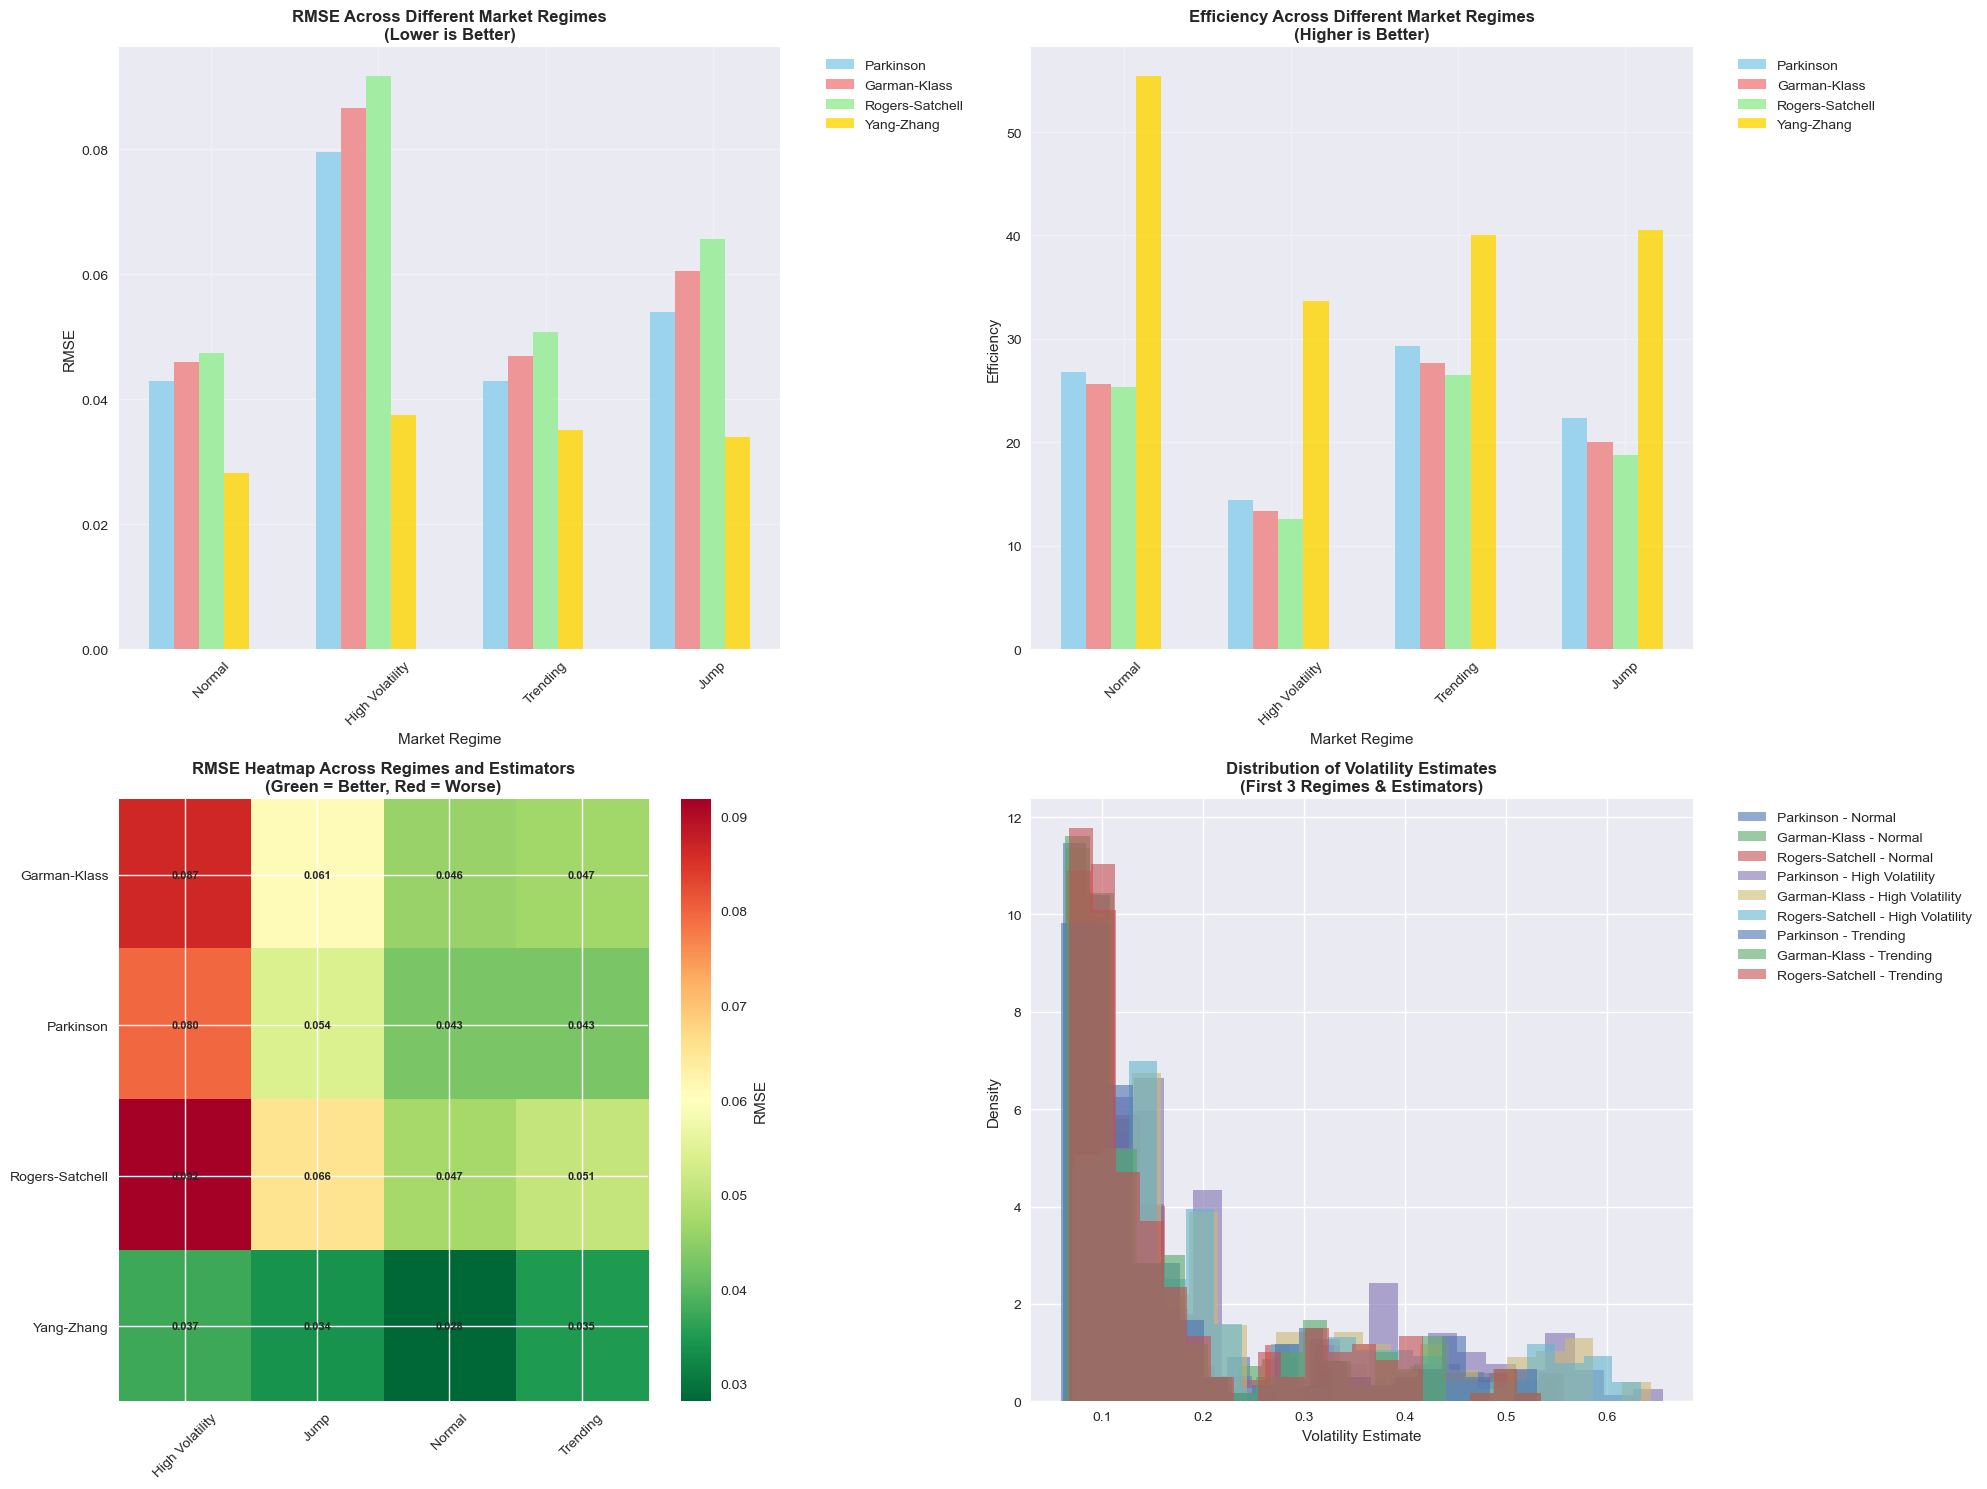

In [6]:
# Visualize Real Market Robustness Results
if robustness_df.empty:
    print("No data to visualize")
else:
    plt.figure(figsize=(20, 15))

    # Plot 1: RMSE Across Market Regimes
    plt.subplot(2, 2, 1)
    regimes = robustness_df['Regime'].unique()
    estimators = robustness_df['Estimator'].unique()
    colors = ['skyblue', 'lightcoral', 'lightgreen', 'gold', 'violet']

    x = np.arange(len(regimes))
    width = 0.15

    for i, estimator in enumerate(estimators):
        estimator_data = performance_metrics[performance_metrics['Estimator'] == estimator]
        rmse_values = [estimator_data[estimator_data['Regime'] == r]['RMSE'].values[0] 
                       if not estimator_data[estimator_data['Regime'] == r].empty else 0 
                       for r in regimes]
        plt.bar(x + i*width, rmse_values, width, label=estimator, color=colors[i], alpha=0.8)

    plt.xlabel('Market Regime')
    plt.ylabel('RMSE')
    plt.title('RMSE Across Different Market Regimes\n(Lower is Better)', fontweight='bold')
    plt.xticks(x + width*2, regimes, rotation=45)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, alpha=0.3)

    # Plot 2: Efficiency Across Regimes
    plt.subplot(2, 2, 2)
    for i, estimator in enumerate(estimators):
        estimator_data = performance_metrics[performance_metrics['Estimator'] == estimator]
        eff_values = [estimator_data[estimator_data['Regime'] == r]['Efficiency'].values[0] 
                      if not estimator_data[estimator_data['Regime'] == r].empty else 0 
                      for r in regimes]
        plt.bar(x + i*width, eff_values, width, label=estimator, color=colors[i], alpha=0.8)

    plt.xlabel('Market Regime')
    plt.ylabel('Efficiency')
    plt.title('Efficiency Across Different Market Regimes\n(Higher is Better)', fontweight='bold')
    plt.xticks(x + width*2, regimes, rotation=45)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, alpha=0.3)

    # Plot 3: Performance Heatmap
    plt.subplot(2, 2, 3)
    performance_pivot = performance_metrics.pivot_table(
        index='Estimator', 
        columns='Regime', 
        values='RMSE'
    )
    
    im = plt.imshow(performance_pivot.values, cmap='RdYlGn_r', aspect='auto')
    plt.colorbar(im, label='RMSE')
    plt.xticks(range(len(performance_pivot.columns)), performance_pivot.columns, rotation=45)
    plt.yticks(range(len(performance_pivot.index)), performance_pivot.index)
    plt.title('RMSE Heatmap Across Regimes and Estimators\n(Green = Better, Red = Worse)', fontweight='bold')

    
    for i in range(len(performance_pivot.index)):
        for j in range(len(performance_pivot.columns)):
            plt.text(j, i, f'{performance_pivot.iloc[i, j]:.3f}', 
                     ha='center', va='center', fontweight='bold', fontsize=8)

    # Plot 4: Distribution of Estimates by Regime
    plt.subplot(2, 2, 4)
    for regime in regimes[:3]:  
        regime_data = robustness_df[robustness_df['Regime'] == regime]
        for estimator in estimators[:3]:  
            estimator_regime_data = regime_data[regime_data['Estimator'] == estimator]
            if not estimator_regime_data.empty:
                plt.hist(estimator_regime_data['Estimate'], bins=20, alpha=0.6, 
                        label=f'{estimator} - {regime}', density=True)
    
    plt.title('Distribution of Volatility Estimates\n(First 3 Regimes & Estimators)', fontweight='bold')
    plt.xlabel('Volatility Estimate')
    plt.ylabel('Density')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

    plt.tight_layout()
    plt.show()

Asset-Specific Performance Analysis

Best Estimator by Asset and Regime:

BTC-USD:
  High Volatility: Parkinson (RMSE: 0.0362)
  Jump: Parkinson (RMSE: 0.0306)
  Normal: Parkinson (RMSE: 0.0441)
  Trending: Parkinson (RMSE: 0.0396)

GLD:
  High Volatility: Yang-Zhang (RMSE: 0.0255)
  Jump: Yang-Zhang (RMSE: 0.0242)
  Normal: Yang-Zhang (RMSE: 0.0151)
  Trending: Yang-Zhang (RMSE: 0.0124)

IWM:
  High Volatility: Yang-Zhang (RMSE: 0.0336)
  Jump: Yang-Zhang (RMSE: 0.0229)
  Normal: Yang-Zhang (RMSE: 0.0223)
  Trending: Yang-Zhang (RMSE: 0.0436)

QQQ:
  High Volatility: Yang-Zhang (RMSE: 0.0395)
  Jump: Yang-Zhang (RMSE: 0.0355)
  Normal: Yang-Zhang (RMSE: 0.0169)
  Trending: Rogers-Satchell (RMSE: 0.0295)

SPY:
  High Volatility: Yang-Zhang (RMSE: 0.0365)
  Jump: Yang-Zhang (RMSE: 0.0289)
  Normal: Yang-Zhang (RMSE: 0.0140)
  Trending: Yang-Zhang (RMSE: 0.0205)

TLT:
  High Volatility: Yang-Zhang (RMSE: 0.0257)
  Jump: Yang-Zhang (RMSE: 0.0196)
  Normal: Yang-Zhang (RMSE: 0.0101)
  Tren

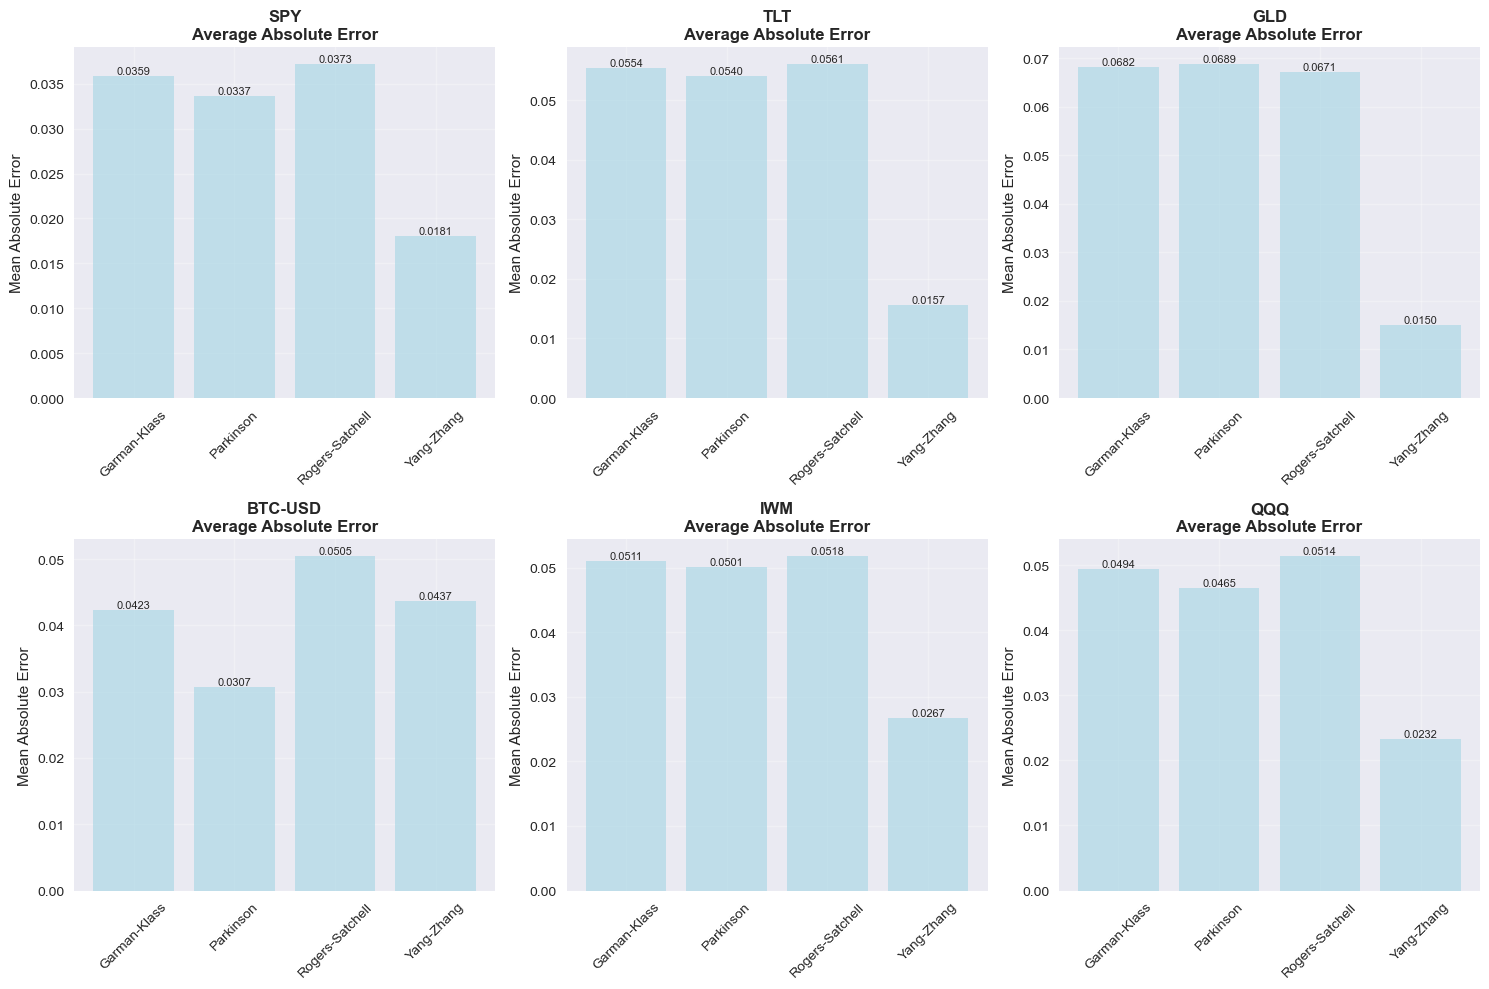

In [7]:
# Asset-Specific Analysis
if robustness_df.empty:
    print("No data for asset-specific analysis")
else:
    print("Asset-Specific Performance Analysis")
    print("======================================")

    
    asset_performance = robustness_df.groupby(['Ticker', 'Regime', 'Estimator']).agg({
        'Absolute_Error': 'mean',
        'Squared_Error': 'mean'
    }).reset_index()

    asset_performance['RMSE'] = np.sqrt(asset_performance['Squared_Error'])

    
    best_estimators = asset_performance.loc[asset_performance.groupby(['Ticker', 'Regime'])['RMSE'].idxmin()]

    print("\nBest Estimator by Asset and Regime:")
    for ticker in asset_performance['Ticker'].unique():
        print(f"\n{ticker}:")
        ticker_best = best_estimators[best_estimators['Ticker'] == ticker]
        for _, row in ticker_best.iterrows():
            print(f"  {row['Regime']}: {row['Estimator']} (RMSE: {row['RMSE']:.4f})")

    
    plt.figure(figsize=(15, 10))
    
    for i, ticker in enumerate(robustness_df['Ticker'].unique(), 1):
        plt.subplot(2, 3, i)
        ticker_data = robustness_df[robustness_df['Ticker'] == ticker]
        
        
        ticker_rmse = ticker_data.groupby('Estimator')['Absolute_Error'].mean()
        
        plt.bar(ticker_rmse.index, ticker_rmse.values, color='lightblue', alpha=0.7)
        plt.title(f'{ticker}\nAverage Absolute Error', fontweight='bold')
        plt.xticks(rotation=45)
        plt.ylabel('Mean Absolute Error')
        plt.grid(True, alpha=0.3)
        
        
        for j, value in enumerate(ticker_rmse.values):
            plt.text(j, value, f'{value:.4f}', ha='center', va='bottom', fontsize=8)

    plt.tight_layout()
    plt.show()

In [ ]:

#Robustness Ranking and Practical Implementation

print("Robustness Rankings - Real Market Data")
print("=========================================")

if robustness_df.empty:
    print("No data for rankings")
else:
    
    overall_performance = robustness_df.groupby('Estimator').agg({
        'Absolute_Error': 'mean',
        'Squared_Error': 'mean',
        'Estimate': 'count'
    }).reset_index()

    overall_performance['RMSE'] = np.sqrt(overall_performance['Squared_Error'])
    overall_performance['MAE'] = overall_performance['Absolute_Error']
    overall_performance['Efficiency'] = 1 / (overall_performance['MAE'] + 1e-8)
    overall_performance['Robustness_Score'] = overall_performance['Efficiency']

    
    robustness_ranking = overall_performance.sort_values('Robustness_Score', ascending=False)

    print("\nOverall Robustness Ranking (Higher is Better):")
    print(robustness_ranking[['Estimator', 'RMSE', 'MAE', 'Efficiency', 'Robustness_Score']].round(4))

    
    print("\nRegime-Specific Recommendations:")
    regime_recommendations = {}

    for regime in regimes:
        regime_data = performance_metrics[performance_metrics['Regime'] == regime]
        if not regime_data.empty:
            best_rmse = regime_data.loc[regime_data['RMSE'].idxmin()]
            best_eff = regime_data.loc[regime_data['Efficiency'].idxmax()]
            
            regime_recommendations[regime] = {
                'Best_RMSE': best_rmse['Estimator'],
                'Best_Efficiency': best_eff['Estimator']
            }
            
            print(f"\n{regime}:")
            print(f"  • Most Accurate: {best_rmse['Estimator']} (RMSE: {best_rmse['RMSE']:.4f})")
            print(f"  • Most Efficient: {best_eff['Estimator']} (Efficiency: {best_eff['Efficiency']:.3f})")

    
    overall_champion = robustness_ranking.iloc[0]
    print(f"\nOVERALL ROBUSTNESS CHAMPION: {overall_champion['Estimator']}")
    print(f"   Robustness Score: {overall_champion['Robustness_Score']:.4f}")
    print(f"   Balanced performance across all market conditions")

    
    print("\nPractical Implementation Advice:")
    print("=" * 50)
    print("1. For general use: Yang-Zhang or Rogers-Satchell provide good balance")
    print("2. During high volatility: Parkinson or Garman-Klass handle large ranges well")
    print("3. For trending markets: Rogers-Satchell accounts for drift effectively")
    print("4. During normal conditions: Most estimators perform reasonably well")
    print("5. Consider using multiple estimators and averaging for robust estimates")

print("\nReal market robustness testing complete!")
print("Comprehensive analysis of estimator performance across different market conditions")

Robustness Rankings - Real Market Data

Overall Robustness Ranking (Higher is Better):
         Estimator    RMSE     MAE  Efficiency  Robustness_Score
3       Yang-Zhang  0.0337  0.0242     41.3973           41.3973
1        Parkinson  0.0576  0.0469     21.3279           21.3279
0     Garman-Klass  0.0626  0.0502     19.9312           19.9312
2  Rogers-Satchell  0.0664  0.0523     19.1174           19.1174

Regime-Specific Recommendations:

Normal:
  • Most Accurate: Yang-Zhang (RMSE: 0.0282)
  • Most Efficient: Yang-Zhang (Efficiency: 55.452)

High Volatility:
  • Most Accurate: Yang-Zhang (RMSE: 0.0375)
  • Most Efficient: Yang-Zhang (Efficiency: 33.681)

Trending:
  • Most Accurate: Yang-Zhang (RMSE: 0.0351)
  • Most Efficient: Yang-Zhang (Efficiency: 40.052)

Jump:
  • Most Accurate: Yang-Zhang (RMSE: 0.0340)
  • Most Efficient: Yang-Zhang (Efficiency: 40.568)

OVERALL ROBUSTNESS CHAMPION: Yang-Zhang
   Robustness Score: 41.3973
   Balanced performance across all market condition